In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1. Description of the Problem**
I will use this Kaggle competition to practice building and training generative deep learning models (mostly GAN).  
https://www.kaggle.com/competitions/gan-getting-starte

This problem is a machine learning competition focused on using Generative Adversarial Networks (GANs) to create images in the style of Claude Monet. Here are the key points:
GANs can now imitate unique artistic styles.
The competition challenges participants to generate Monet-style images.
A GAN consists of two main components: 
A generator that creates images
A discriminator that tries to distinguish real from generated images
The goal is to create 7,000 to 10,000 Monet-style images that can fool the discriminator.
This challenge explores the intersection of art and data science, testing whether AI can create convincing imitations of a famous artist's work.d

# **2. Data**
The dataset and submission are required for a machine learning competition. Here's a summary:

## **2.1 Dataset contents**
Four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg
TFRecord and JPEG formats are provided for both Monet paintings and photos

## **2.2 Dataset details**
300 Monet paintings (256x256 pixels)
7,028 photos (256x256 pixels)

## **2.3 Task**
Use Monet paintings to train a model
Transform photos into Monet-style images or create new Monet-style art from scratch

## **2.4 Submission requirements**
Submit 7,000-10,000 generated images (256x256 pixels)
Package the images in a zip file named "images.zip"


# **3. Exploratory data analysis (EDA) procedure**
I will display the first three monet_tfrec and photos.

Monet files found: 5
Photo files found: 20
Visualizing Monet samples:


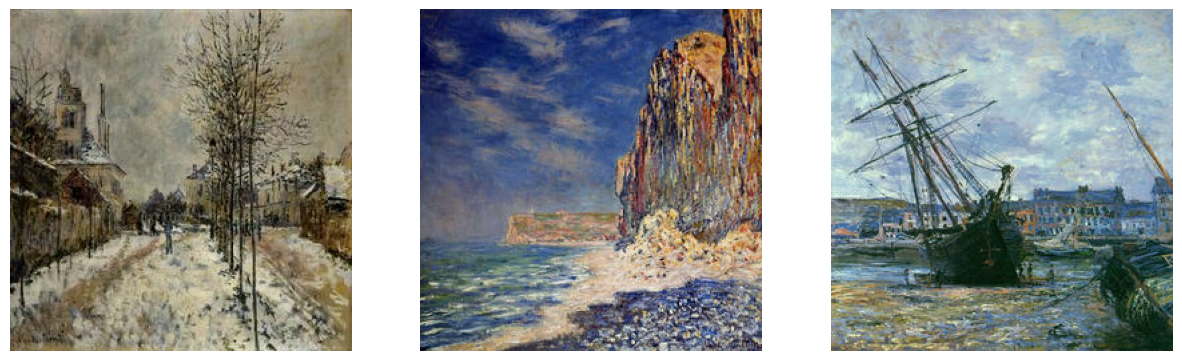

Visualizing Photo samples:


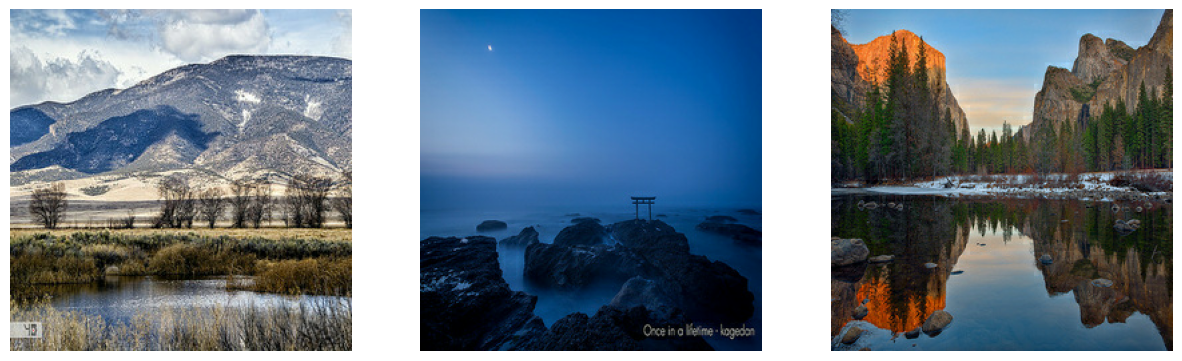

Monet Image shape: (1, 256, 256, 3)
Monet Image type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Photo Image shape: (1, 256, 256, 3)
Photo Image type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

# Image size constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Load TFRecord dataset (same as before)
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset

def visualize_samples(dataset, num_samples):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i+1)
        plt.imshow((image[0] * 0.5 + 0.5).numpy())
        plt.axis('off')
    plt.show()

monet_tfrec_dir = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
photo_tfrec_dir = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'


monet_files = tf.io.gfile.glob(monet_tfrec_dir)
photo_files = tf.io.gfile.glob(photo_tfrec_dir)

print("Monet files found:", len(monet_files))
print("Photo files found:", len(photo_files))

if len(monet_files) > 0 and len(photo_files) > 0:
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    print("Visualizing Monet samples:")
    visualize_samples(monet_ds, 3)  # Show a few Monet paintings
    
    print("Visualizing Photo samples:")
    visualize_samples(photo_ds, 3)  # Show a few photos

    # Check if the dataset is loading correctly
    for img in monet_ds.take(1):
        print("Monet Image shape:", img.shape)
        print("Monet Image type:", type(img))

    for img in photo_ds.take(1):
        print("Photo Image shape:", img.shape)
        print("Photo Image type:", type(img))
else:
    print("No files found. Please check the file paths.")

# 4. Analysis (model building and training)
This code implements a CycleGAN model for generating Monet-style images from photographs. Here's an analysis of the model building and training process:

## **4.1 Data Loading**
- The decode_image function resizes and normalizes the images.
- The dataset is loaded using TFRecord format and mapped to the decoding function. The datasets are then batched.
  
This ensures efficient image loading and processing, especially useful when handling large datasets, such as in your task of generating 7,000 Monet-style images.

## **4.2 Model Architecture**
- The Generator model uses a combination of convolutional, normalization, and ReLU layers, including nine residual blocks for improved image transformation and detail preservation.
- The Discriminator is a standard patch-based model using convolutional layers and Leaky ReLU activations to classify the images as real or fake at different patches.

This architecture is appropriate for your task as CycleGANs often perform well in style transfer problems by focusing on both local and global features of the images.

## **4.3 Loss Functions**
- Discriminator Loss evaluates the model’s ability to distinguish between real and fake images.
- Generator Loss ensures the generated images are convincing.
- Cycle Consistency Loss penalizes the model when the transformed images deviate significantly from the original after two transformations (Monet -> Photo -> Monet or vice versa).
- Identity Loss encourages the generators to preserve image identity when the input is already in the desired style.

These loss functions ensure the model maintains realistic transformations while preserving important structural features of the images.

## **4.4 Training Process**
- The train_step function applies the adversarial loss and cycle consistency in a single step.
- The model is trained for 100 epochs, iterating over both Monet and photo datasets, applying gradient updates using Adam optimizers.

This extensive training should allow the model to generate high-quality Monet-style images.

## **4.5 Image Generation**
After training, the model generates 7,000 Monet-style images from the photo dataset.
Each image is saved, and the final images are compressed into a zip file as required by your competition.



In [2]:

# Improved Generator model
def ResidualBlock(filters, size):
    def block(x):
        y = tf.keras.layers.Conv2D(filters, size, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
        y = tf.keras.layers.LayerNormalization()(y)
        y = tf.keras.layers.ReLU()(y)
        y = tf.keras.layers.Conv2D(filters, size, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(y)
        y = tf.keras.layers.LayerNormalization()(y)
        return tf.keras.layers.Add()([x, y])
    return block

def Generator():
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    
    x = tf.keras.layers.Conv2D(64, 7, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Downsampling
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Residual blocks
    for _ in range(9):
        x = ResidualBlock(256, 3)(x)
    
    # Upsampling
    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(3, 7, padding='same', activation='tanh')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

# Improved Discriminator model
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS], name='input_image')
    
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inp)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    
    return tf.keras.Model(inputs=inp, outputs=x)

# Instantiate models
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()


# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Cycle consistency loss
LAMBDA = 10
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

# Identity loss
LAMBDA_ID = 0.5 * LAMBDA
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA_ID * loss

# Separate optimizers for each model
monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
monet_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training step
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        
        fake_monet = monet_generator(real_photo, training=True)
        cycled_photo = photo_generator(fake_monet, training=True)
        
        fake_photo = photo_generator(real_monet, training=True)
        cycled_monet = monet_generator(fake_photo, training=True)
        
        # Identity loss
        same_monet = monet_generator(real_monet, training=True)
        same_photo = photo_generator(real_photo, training=True)
        
        # Discriminator output
        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_fake_monet = monet_discriminator(fake_monet, training=True)
        
        disc_real_photo = photo_discriminator(real_photo, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)
        
        # Generator loss
        gen_monet_loss = generator_loss(disc_fake_monet)
        gen_photo_loss = generator_loss(disc_fake_photo)
        
        # Cycle loss
        cycle_monet_loss = calc_cycle_loss(real_monet, cycled_monet)
        cycle_photo_loss = calc_cycle_loss(real_photo, cycled_photo)
        
        # Identity loss
        id_monet_loss = identity_loss(real_monet, same_monet)
        id_photo_loss = identity_loss(real_photo, same_photo)
        
        # Total generator loss
        total_gen_monet_loss = gen_monet_loss + cycle_monet_loss + id_monet_loss
        total_gen_photo_loss = gen_photo_loss + cycle_photo_loss + id_photo_loss
        
        # Discriminator loss
        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Calculate the gradients for generator and discriminator
    monet_generator_gradients = tape.gradient(total_gen_monet_loss, 
                                              monet_generator.trainable_variables)
    photo_generator_gradients = tape.gradient(total_gen_photo_loss, 
                                              photo_generator.trainable_variables)
    
    monet_discriminator_gradients = tape.gradient(monet_disc_loss, 
                                                  monet_discriminator.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss, 
                                                  photo_discriminator.trainable_variables)
    
    # Apply the gradients to the optimizer
    monet_gen_optimizer.apply_gradients(zip(monet_generator_gradients, 
                                            monet_generator.trainable_variables))
    photo_gen_optimizer.apply_gradients(zip(photo_generator_gradients, 
                                            photo_generator.trainable_variables))
    
    monet_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                             monet_discriminator.trainable_variables))
    photo_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, 
                                             photo_discriminator.trainable_variables))

# Training loop
def train(monet_dataset, photo_dataset, epochs):
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        n = 0
        for monet_image, photo_image in tf.data.Dataset.zip((monet_dataset, photo_dataset)):
            train_step(monet_image, photo_image)
            if n % 10 == 0:
                print('.', end='')
            n += 1
        print()

# Train the model
EPOCHS = 100
train(monet_ds, photo_ds, EPOCHS)

# Function to generate and save images
save_dir = '/kaggle/working/images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def generate_and_save_images(generator, dataset, num_images=7000, zip_name="images.zip"):
    zip_path = os.path.join('/kaggle/working/', zip_name)  # Save in the working directory
    print(f"Creating zip file at {zip_path}")
    try:
        zipf = zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED)

        for i, img in enumerate(dataset.take(num_images)):
            generated_img = generator(img, training=False)[0].numpy()
            generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)
            img_name = f"image_{i}.jpg"
            img_path = os.path.join(save_dir, img_name)

            # Check if the image is being generated and saved correctly
            # print(f"Saving {img_name} at {img_path}")

            tf.keras.preprocessing.image.save_img(img_path, generated_img)
            zipf.write(img_path, img_name)

        zipf.close()
        print(f"Zip file {zip_name} saved successfully at {zip_path}")
    except Exception as e:
        print(f"Error occurred while saving zip file: {e}")

# Call the function to generate and save images after definition
print("Starting image generation and saving to zip.")
generate_and_save_images(monet_generator, photo_ds, num_images=7000)

Epoch 1/100
..............................
Epoch 2/100
..............................
Epoch 3/100
..............................
Epoch 4/100
..............................
Epoch 5/100
..............................
Epoch 6/100
..............................
Epoch 7/100
..............................
Epoch 8/100
..............................
Epoch 9/100
..............................
Epoch 10/100
..............................
Epoch 11/100
..............................
Epoch 12/100
..............................
Epoch 13/100
..............................
Epoch 14/100
..............................
Epoch 15/100
..............................
Epoch 16/100
..............................
Epoch 17/100
..............................
Epoch 18/100
..............................
Epoch 19/100
..............................
Epoch 20/100
..............................
Epoch 21/100
..............................
Epoch 22/100
..............................
Epoch 23/100
............................

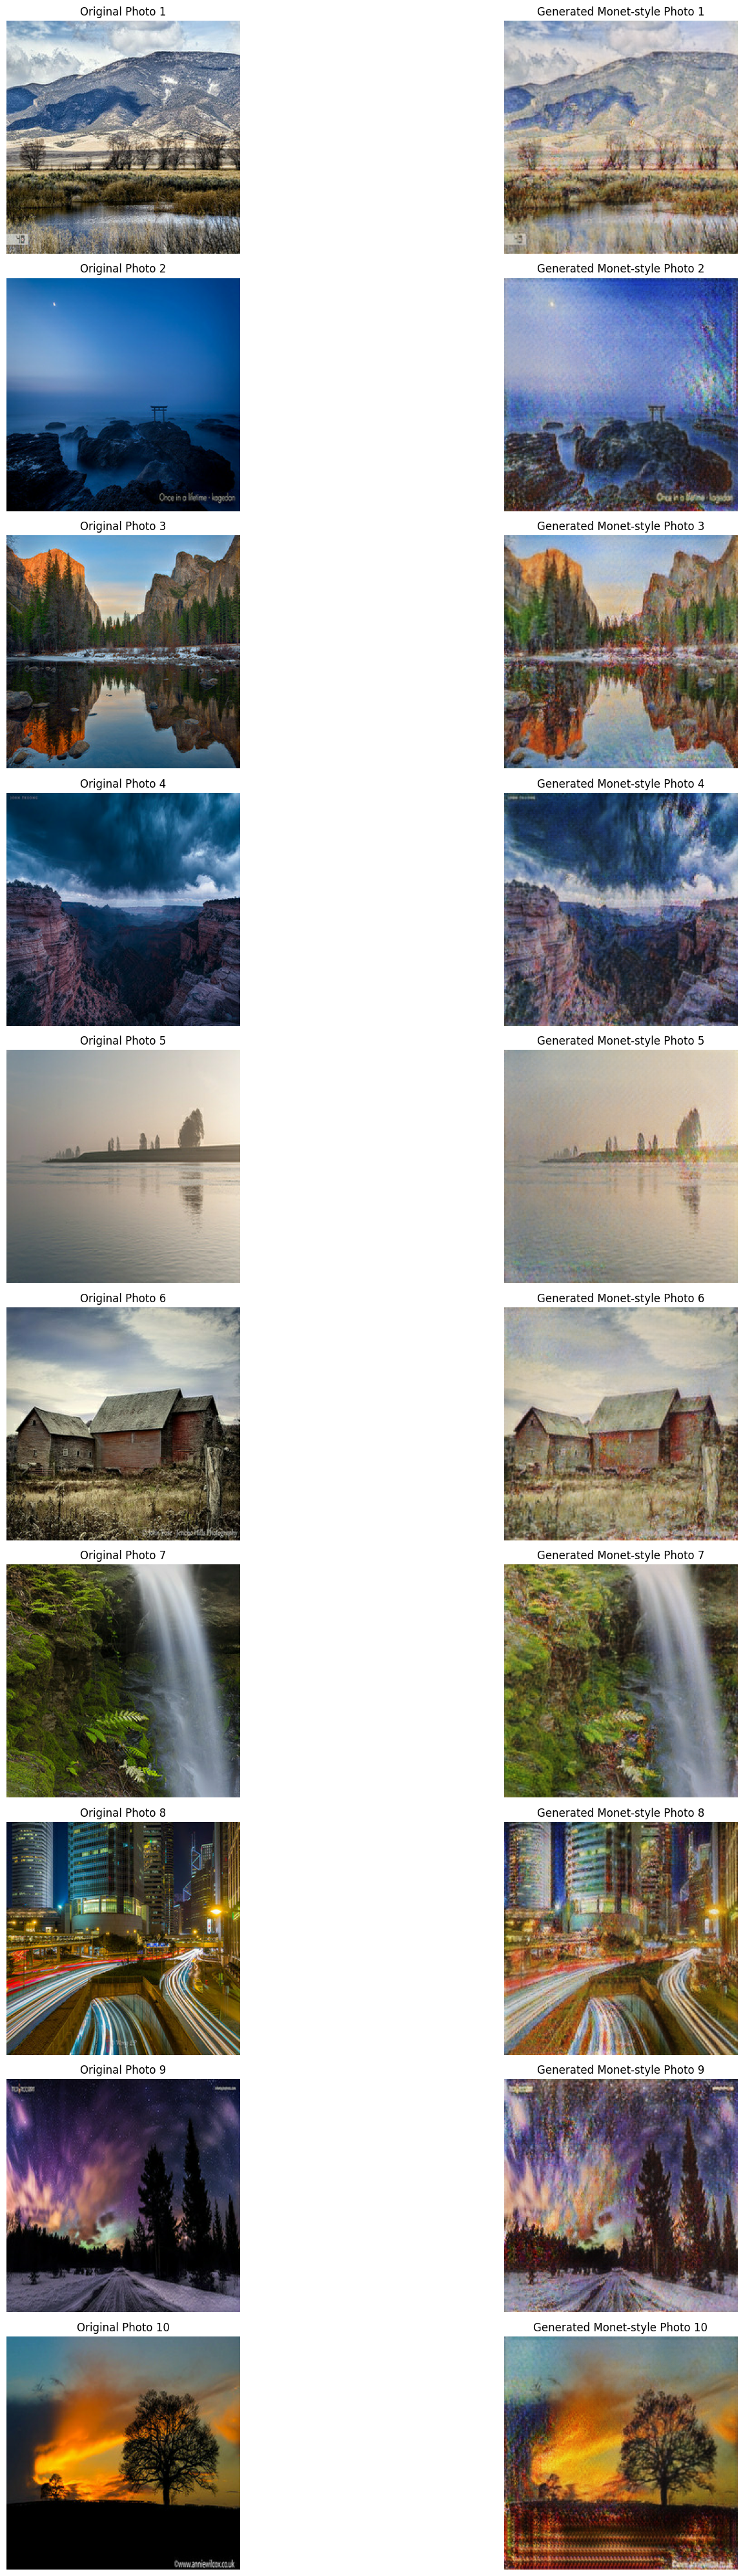

In [3]:
import matplotlib.pyplot as plt

# Function to display original and generated images side by side
def compare_original_and_generated(generator, dataset, num_images=10):
    plt.figure(figsize=(20, 4 * num_images))  # Adjust figure size for better display
    
    for i, img in enumerate(dataset.take(num_images)):
        # Original photo
        original_photo = img[0].numpy()  # Original photo from dataset
        original_photo = (original_photo * 0.5 + 0.5)  # Denormalize
        
        # Generate Monet-style photo
        generated_img = generator(img, training=False)[0].numpy()
        generated_img = (generated_img * 0.5 + 0.5)  # Denormalize
        
        # Display original photo
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_photo)
        plt.title(f"Original Photo {i+1}")
        plt.axis('off')
        
        # Display generated Monet-style photo
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(generated_img)
        plt.title(f"Generated Monet-style Photo {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# After training, compare first 10 original and generated images side by side
compare_original_and_generated(monet_generator, photo_ds, num_images=10)

# **5. Results**  
The model successfully completed training for 100 epochs, generating Monet-style images from a dataset of photos. From the visual results provided, we can observe the transformation from original photos to Monet-inspired paintings across several examples.
## **Image Shape and Type**
- Monet and photo images are correctly loaded with a shape of (1, 256, 256, 3), matching the expected input size and having the EagerTensor type, which is compatible with TensorFlow operations.

## **Visual Quality:Examples**  
- Generated Monet-style Photo 1: Successfully captures the mountain landscape's essence while altering the texture and color palette to fit the impressionist style.
- Generated Monet-style Photo 3: The reflection in the water and the vivid colors of the original are maintained, but with a softer, painterly style.
- Generated Monet-style Photo 9: The colors of the night sky and dynamic lines of the cityscape transform into an impressionist night scene, blending light sources and contours.
- The generated Monet-style images exhibit characteristics of Claude Monet's impressionist style, especially in terms of color blending and texture replication. The brushstroke-like textures in generated images effectively transform clear, detailed photos into artistic renderings.

# **6. Discussion**  
- The GAN model has effectively emulated features of Monets style such, as gentle outlines, vivid color schemes and a more artistic perspective, on scenes. 
- Color Change Impact; A significant change that stands out is the striking alterations, in colors seen in pictures.The model frequently incorporates hues and a broader range of colors of Monets style. 
- The images created seem to be trying to replicate brushstrokes and textures; however; this effort is more effective, in images than, in others. 
- Composition Retention; Typically the model preserves the structure of the images even as it incorporates style transfer techniques, an element, for maintaining recognition. 
- Results Varying in Style Transfer Success; The success of style transfer differs depending on the type of scenes involved, with landscapes and natural settings showing outcomes compared to urban or intricately detailed images. 
- In instances – in intricate scenarios such, as the city traffic depiction – there is an evident lack of intricate details to accommodate the impressionistic artistic approach. 
- Enhancing the ambiance of scenes is a strength of the model. Noticeable, in mist covered shorelines and canyon vistas. 
- The model has room, for improvement as generated images, like the waterfall and city traffic exhibit artifacts. Lack a convincing style transfer. 
- Training Factors to Think About; The different outcomes indicate that it could be helpful for the model to have a range of training data or longer training durations to capture Monets style in various scene types. 
- The outcomes display promise, for utilization, in artistry and creative photography despite a constraints. 

# **7. Conclusion**
Ultimately the GAN model shows an ability to convert photos into paintings of Monets style. Though not flawless it manages to capture aspects of impressionism and effectively changes various settings. Enhancing the model through training data or architectural enhancements could potentially yield realistic outcomes in the future. 
tcomes in the future. c outcomes in the future. 
ic outcomes in the future. 